# Introduction to the DEA Wetlands Insight Tool (WIT) <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://knowledge.dea.ga.gov.au/guides/setup/Sandbox/sandbox/) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_wo_3),
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_fc_3)

> **Note:** [ga_ls9c_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls9c_ard_3) can be included once derivative Water Observations and Fractional Cover products have been generated

## Background

Wetlands provide a wide range of ecosystem services including improving water quality, carbon sequestration, as well as providing habitat for fish, amphibians, reptiles and birds.  Managing wetlands in Australia is challenging due to competing pressures for water availability and highly variable climatic settings.  The DEA Wetlands Insight Tool has been developed to provide catchment managers, environmental water holders, and wetlands scientists a consistent historical baseline of wetlands dynamics from 1987 onwards. 

The DEA Wetlands Insight Tool summarises how the amount of water, green vegetation, dry vegetation and bare soil varies over time within each wetland. It provides the user with the ability to compare how the wetland is behaving now with how it has behaved in the past.  This allows users to identify how changes in water availability have affected the wetland. It achieves this by presenting a combined view of Water Observations from Space, Tasseled Cap Wetness and Fractional Cover measurements from the Landsat series of satellites, summarised as a stacked line plot to show how that wetland has changed over time. 

## Expected output
This notebook demonstrates the method for reproducing results from the Wetlands Insight Tool. 
At the end of the notebook you will display and save a WIT plot: 

<img width="1200" height="300" align="left" src="../Supplementary_data/DEA_Wetlands_Insight_Tool/Hird_Swamp.png">

## Applications
The product is designed to support wetland managers, catchment managers and environmental waterholders in understanding whether or not wetlands are changing over time.  In instances where the wetlands are changing, the tool allows users to identify whether the changes are gradual, rapid, once-off or cyclical in nature.  For example the response of wetlands to the following drivers can be assessed:

* Changes in river flow volumes
* Changes in flood frequency
* Long term shifts in rainfall
* Wet-season/Dry-season shifts in water availability
* Invasive weeds
* Environmental watering events

Care should be used when interpreting Wetlands Insight Tool results as increases/decreases in particular cover types can be associated with different processes.  For example an increase in green cover could indicate canopy recovery of desirable wetland species or an increase in the amount of invasive weeds.

## Publications
* Dunn, B., Ai, E., Alger, M.J., Fanson, B., Fickas, K.C., Krause, C.E., Lymburner, L., Nanson, R., Papas, P., Ronan, M., Thomas, R.F., 2023. Wetlands Insight Tool: Characterising the Surface Water and Vegetation Cover Dynamics of Individual Wetlands Using Multidecadal Landsat Satellite Data. Wetlands 43, 37. Available: https://doi.org/10.1007/s13157-023-01682-7
* Dunn, B., Lymburner, L., Newey, V., Hicks, A. and Carey, H., 2019. Developing a Tool for Wetland Characterization Using Fractional Cover, Tasseled Cap Wetness And Water Observations From Space. IGARSS 2019 - 2019 IEEE International Geoscience and Remote Sensing Symposium, 2019, pp. 6095-6097. Available: https://doi.org/10.1109/IGARSS.2019.8897806.
* Krause, C., Dunn, B., Bishop-Taylor, R., Adams, C., Burton, C., Alger, M., Chua, S., Phillips, C., Newey, V., Kouzoubov, K., Leith, A., Ayers, D., Hicks, A., DEA Notebooks contributors 2021. Digital Earth Australia notebooks and tools repository. Geoscience Australia, Canberra. https://doi.org/10.26186/145234

**Please cite Dunn et. al 2023 and Krause et al 2021 when using the results of this notebook, and contact us as we'd love to hear about your use case! 
Licencing information is provided at the bottom of this notebook, and requires attribution.** 

## Related products
* [DEA Fractional Cover](https://knowledge.dea.ga.gov.au/data/product/dea-fractional-cover-landsat/?tab=overview)
* [DEA Tasseled Cap Indices Percentiles Calendar Year (Landsat)](https://knowledge.dea.ga.gov.au/data/product/dea-tasseled-cap-percentiles-landsat/?tab=overview)
* [DEA Water Observations (Landsat)](https://knowledge.dea.ga.gov.au/data/product/dea-water-observations-landsat/?tab=overview)

## WIT calculation

For each pixel, we calculate its WIT values based on the method of [Dunn, et al., 2023](https://doi.org/10.1007/s13157-023-01682-7).
The calculation in this flowchart below shows the workflow implemented in this notebook.

![](../Supplementary_data/DEA_Wetlands_Insight_Tool/WIT_notebook_flowchart.png)

## Getting Started

### Load packages

In [1]:
import datetime
import geopandas as gpd
import itertools
import numpy as np
import pandas as pd
import xarray as xr

import datacube

import sys

sys.path.insert(1, "../Tools/")
import dea_tools.bandindices
import dea_tools.datahandling
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster
import dea_tools.wetlands

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/bex.dunn@ga.gov.au/proxy/8787/status,
Dashboard: /user/bex.dunn@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38641,Workers: 1
Dashboard: /user/bex.dunn@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:37031,Total threads: 2
Dashboard: /user/bex.dunn@ga.gov.au/proxy/43733/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38977,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="DEA_Wetlands_Insight_Tool")

### Analysis parameters
* `poly`: The polygon of your wetland of interest. This can be a shapefile or a GeoJSON. User will need to drag and drop the file into the sandbox and update the file path. Your polygon should be in EPSG:3577 [GDA94 Australian Albers](https://epsg.io/3577).

### Load a shapefile that describes your wetland study area

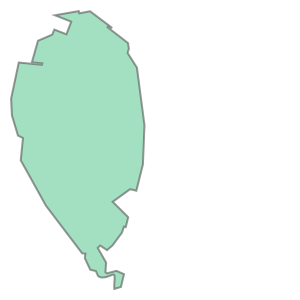

In [3]:
# This cell loads and plots the wetlands polygon. If no output, check your polygon
poly = gpd.read_file("../Supplementary_data/DEA_Wetlands_Insight_Tool/hird.shp")
poly.geometry[0]

In [4]:
# Specifying coordinate reference system of the polygon.
gpgon = datacube.utils.geometry.Geometry(poly.geometry[0], crs=poly.crs)

In [5]:
# Select time period. Consistent data is available from 01-09-1987.
time = ("2014-01-01", "2016-01-01")
# time = ('1985-01-01', '2024-01-01')

## Load Landsat, Water Observations, and Fractional Cover:

### Load and mask Landsat data

Load Landsat 5, 7 and 8 data. Not including Landsat 7 SLC off period (31-05-2003 to 06-04-2022). If the following cell successfully loads data, it will generate output text, similar to:


```
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Loading 8 time steps
```

For further information on the functions used here, go to the [function documentation](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py).

In [6]:
# Define which spectral bands are being used in the analysis
bands = [
    f"nbart_{band}" for band in ("blue", "green", "red", "nir", "swir_1", "swir_2")
]

# Load Landsat 5, 7 and 8 data. Not including Landsat 7 SLC off period (31-05-2003 to 06-04-2022).
ds = dea_tools.datahandling.load_ard(
    dc,
    products=["ga_ls8c_ard_3", "ga_ls7e_ard_3", "ga_ls5t_ard_3"],
    ls7_slc_off=False,
    measurements=bands,
    geopolygon=gpgon,
    output_crs="EPSG:3577",
    resolution=(-30, 30),
    resampling={"fmask": "nearest", "*": "bilinear"},
    time=time,
    group_by="solar_day",
    dask_chunks={},
)

# Load into memory using Dask
ds.load()

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 89 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 89, y: 127, x: 61)
Coordinates:
  * time          (time) datetime64[ns] 2014-01-05T00:10:35.094128 ... 2015-1...
  * y             (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * x             (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 791.0 728.0 707.0 754.0 ... nan nan nan
    nbart_green   (time, y, x) float32 1.097e+03 1.025e+03 990.0 ... nan nan nan
    nbart_red     (time, y, x) float32 1.422e+03 1.339e+03 1.293e+03 ... nan nan
    nbart_nir     (time, y, x) float32 2.151e+03 2.009e+03 1.957e+03 ... nan nan
    nbart_swir_1  (time, y, x) float32 3.506e+03 3.378e+03 3.314e+03 ... nan nan
    nbart_swir_2  (time, y, x) float32 2.41e+03 2.291e+03 2.245e+03 ... nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load Water Observations and Fractional Cover datasets

Load Fractional Cover and Water Observations data into the same spatial grid and resolution as the loaded Landsat dataset.

In [ ]:
ds_wo = dc.load(
    "ga_ls_wo_3", resampling="nearest", group_by="solar_day", like=ds, dask_chunks={}
)
ds_fc = dc.load(
    "ga_ls_fc_3", resampling="nearest", group_by="solar_day", like=ds, dask_chunks={}
)

# Load data into memory
ds_wo.load()
ds_fc.load()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Locate and remove any observations which aren't in all three datasets

In [ ]:
missing = set()
for t1, t2 in itertools.product(
    [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2
):
    missing_ = set(t1) - set(t2)
    missing |= missing_

ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])

## Calculate Tasseled Cap Wetness from the Landsat data


We use Tasseled Cap Wetness (TCW) to identify areas in wetlands that are wet, but not identified by the WOfS algorithm as open water. This includes areas of mixed vegetation and water like in palustrine wetlands. TCW is the third component of a Tasseled Cap Index analysis and can be thresholded to classify wet pixels (Fisher et al., [2016](https://doi.org/10.1016/j.rse.2015.12.055)). Tasseled Cap Index analysis is a linear principal component analysis of Landsat imagery with a Procrustes’ Rotation (Kauth and Thomas, [1976](http://docs.lib.purdue.edu/lars_symp/159)), producing three components roughly corresponding to brightness (TCB), greenness (TCG) and wetness (TCW; Roberts et al., 2018). The coefficients of Crist ([1985](https://doi.org/10.1016/0034-4257(85)90102-6)) were used to calculate TCW. 

TCW has values between −12,915 and 7032 when applied to DEA Landsat data. As TCW increases, the pixel becomes 
wetter, with open water having TCW values near and above zero (Pasquarella et al., [2016](https://doi.org/10.1002/rse2.24)). We threshold TCW at −350, with values above this threshold used to characterise ‘wet’ pixels. We developed the TCW threshold to identify ‘wet’ pixels by comparing TCW to known inundation extents in the Macquarie Marshes, a large floodplain wetland in the Murray-Darling Basin of south-eastern Australia. We chose the threshold for the WIT workflow to minimise the absolute difference in extent between the observed inundated area and the area of thresholded TCW as described further here: https://link.springer.com/article/10.1007/s13157-023-01682-7#appendices


In [ ]:
tcw = dea_tools.bandindices.calculate_indices(
    ds, index="TCW", collection="ga_ls_3", normalise=False, drop=True, inplace=False
)

### Divide Fractional Cover by 100

Divide the FC values by 100 to keep them in $[0, 1]$ (ignoring for now that values can exceed 100 due to how FC is calculated)
Keeps data types the same in the output raster.

In [ ]:
bs = ds_fc.bs / 100
pv = ds_fc.pv / 100
npv = ds_fc.npv / 100

### Generate the WIT raster bands:

Create an empty dataset called `output_rast` and populate with values from input datasets.

In [ ]:
rast_names = ["pv", "npv", "bs", "wet", "water"]
output_rast = {n: xr.zeros_like(bs) for n in rast_names}

output_rast["bs"].values[:] = bs
output_rast["pv"].values[:] = pv
output_rast["npv"].values[:] = npv

## Masking 

1. Mask pixels not in the polygon

2. Use the [Water Observations bit flags](https://knowledge.dea.ga.gov.au/notebooks/DEA_products/DEA_Water_Observations/#Understanding-WOs-bit-flags) to mask noncontiguous data, low solar incidence angle, cloud, and water out of the `wet` category. We distinguish `open water` from `wet` as mutually exclusive categories. 

## Thresholding

We threshold TCW at −350, with values above this threshold used to characterise ‘wet’ pixels ([Dunn, et al., 2023](https://doi.org/10.1007/s13157-023-01682-7)).

In [ ]:
# Rasterise the shapefile where poly is the vector data and pv is the xarray template
poly_raster = xr_rasterize(poly, pv) > 0

# Mask includes No data, Non contiguous data, Cloud shadow, Cloud, and water.
# See https://knowledge.dea.ga.gov.au/notebooks/DEA_products/DEA_Water_Observations/#Understanding-WOs-bit-flags for more detail.
mask = (ds_wo.water & 0b01100011) == 0
mask &= poly_raster

# Set open water to water present and classified as water as per Water Observations and bit flags
open_water = ds_wo.water & (1 << 7) > 0

# Set wet pixels where not masked and above threshold of -350
wet = tcw.where(mask).TCW > -350

In [ ]:
# Adding wet and water values to output raster

# TCW
output_rast["wet"].values[:] = wet.values.astype(float)
for name in rast_names[:3]:
    output_rast[name].values[wet.values] = 0

# WO
output_rast["water"].values[:] = open_water.values.astype(float)
for name in rast_names[:4]:
    output_rast[name].values[open_water.values] = 0

In [ ]:
# Masking again
ds_wit = xr.Dataset(output_rast).where(mask)

Mask entire observations where the polygon is more than 10% masked:

In [ ]:
# Calculate percentage missing
pc_missing = (~mask).where(poly_raster).mean(dim=["x", "y"])

ds_wit = ds_wit.where(pc_missing < 0.1)

The WIT results are now computed. All that's left is to normalise them.

## Normalise Fractional Cover Values in WIT result

Users are provided the option to normalise the WIT result. Normalisation only affects vegetation Fractional Cover values. We rescale Fractional Cover values by the area of the vegetation so that the total percentage adds to 1. This makes the graph more interpretable and is done as the Fractional Cover algorithm sometimes returns values which add to greater than 1.

We suggest normalisation when displaying the WIT plots but perhaps not if calculating population statistics. 

In [ ]:
# Convert ds_wit: XArray.Dataset to polygon_base_df: pandas.DataFrame

polygon_base_df = pd.DataFrame()
polygon_base_df["date"] = ds_wit.time.values

for band in rast_names:
    polygon_base_df[band] = ds_wit[band].mean(dim=["x", "y"])

In [ ]:
polygon_base_df = dea_tools.wetlands.normalise_wit(polygon_base_df)

## Create WIT Plot

Edit the polygon name in the cell below, if required. A png file will be created in this directory with the same name as the polygon, unless the `png_name` variable below is edited. 

In [ ]:
polygon_name = "Hird Swamp"
png_name = polygon_name  # file will be png_name.png

In [ ]:
dea_tools.wetlands.display_wit_stack_with_df(polygon_base_df, polygon_name, png_name)

## Create WIT Comma-separated values (CSV) output file
The output file will show up in the file explorer in this directory. 


In [ ]:
polygon_base_df.reset_index(drop=True, inplace=True)

In [ ]:
polygon_base_df.set_index('date', inplace=True)

In [ ]:
polygon_base_df.head()

In [ ]:
#set output csv name to polygon name
csv_name = polygon_name
#write WIT dataframe to csv without including the index row
polygon_base_df.to_csv(f"{polygon_name}.csv", index=False)

## WIT CSV data specification table

| measurement     | description                                                                                                                                                                                                                                                                                                                                                                                     | data type      |
|-----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| date            | Date and time of satellite observation in UTC                                                                                                                                                                                                                                                                                                                                                   | datetime64[ns] |
| pv              | Photosynthetic vegetation (pv) fraction. Green vegetation (leaves, grass, growing crops). From the DEA Fractional Cover Product generated using the Joint Remote Sensing Research Program Vegetation Fractional Cover algorithm and calculated as the proportion of the polygon with this cover type, not per pixel.                                                                            | float64        |
| npv             | Non-photosynthetic vegetation (npv) fraction. Brown or dry vegetation (branches, dry grass or hay, and dead leaf litter). From the DEA Fractional Cover Product generated using the Joint Remote Sensing Research Program Vegetation Fractional Cover algorithm and calculated as the proportion of the polygon with this cover type, not per pixel.                                            | float64        |
| bs              | Bare soil (bs) fraction. Bare ground (soil or rock). From the DEA Fractional Cover Product generated using the Joint Remote Sensing Research Program Vegetation Fractional Cover algorithm and calculated as the proportion of the polygon with this cover type, not per pixel.                                                                                                                 | float64        |
| wet             | Wet, not open water. Includes areas of mixed vegetation and water. From a thresholded (> -350) Tasseled Cap Wetness analysis. Calculated as the proportion of the polygon where pixels are not classified as open water or no-data and exceed the threshold by summing pixels.                                                                                                                  | float64        |
| water           | Areas that are classified as open water from the DEA Water Observations Product. Calculated as the proportion of the polygon containing water pixels as a sum.                                                                                                                                                                                                                                  | float64        |
| veg_areas       | 1 - water - wet . Used to normalise FC values.                                                                                                                                                                                                                                                                                                                                                  | float64        |
| overall_veg_num | pv + npv + bs. Used to normalise FC values.                                                                                                                                                                                                                                                                                                                                                     | float64        |
| norm_bs         | bs / vegetation_overall_value * vegetation_area . Normalised values are generated for graph display and only affect Fractional Cover Values, which due to the spectral unmixing algorithm can produce values which sum to greater than 1. We rescale Fractional Cover Values by the area of the vegetation so that the total value is 1. Non-normalised values are for calculating statistics.  | float64        |
| norm_pv         | pv / vegetation_overall_value * vegetation_area .  Normalised values are generated for graph display and only affect Fractional Cover Values, which due to the spectral unmixing algorithm can produce values which sum to greater than 1. We rescale Fractional Cover Values by the area of the vegetation so that the total value is 1. Non-normalised values are for calculating statistics. | float64        |
| norm_npv        | npv / vegetation_overall_value * vegetation_area . Normalised values are generated for graph display and only affect Fractional Cover Values, which due to the spectral unmixing algorithm can produce values which sum to greater than 1. We rescale Fractional Cover Values by the area of the vegetation so that the total value is 1. Non-normalised values are for calculating statistics. | float64        |
| off_value       | off_value is 100 where there is low data quality and 0 for good data. This value indicates low quality data periods, including the Landsat 7 SLC-off period: https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data and periods with an observation density of less than four observations within a twelve month (365 days) period.                                                              | float64        |

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Citations** &mdash; If you use the DEA Notebooks and Tools repository in your work, please reference
it with the following citation:

> Krause, C., Dunn, B., Bishop-Taylor, R., Adams, C., Burton, C., Alger,
> M., Chua, S., Phillips, C., Newey, V., Kouzoubov, K., Leith, A.,
> Ayers, D., Hicks, A., DEA Notebooks contributors 2021. Digital Earth
> Australia notebooks and tools repository. Geoscience Australia,
> Canberra. <https://doi.org/10.26186/145234>

To cite this notebooks' dataset and research papers in your work you can use the [Publications](#Publications) at the top of this notebook.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2024

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags